#### **Leverage Foundational Models in Biology**

**Objective:** Create a workflow for creating protein binders using Nvidia BioNemo framework and NIM microservices. The goal is to propse new sequences, use folding model for new sequences and AlphaFold2 to asses target interaction.

The process involves using RFDiffusion model to create protein backbones, ProteinMPNN to generate sequences and predicting complex structures with AphaFold2. The workflow leverages advanced AI models to design novel protein structures efficiently.
The workflow is a powerful framework for exploring protein design offering precision in generating functional protein binders.

**Workflow**: -- 3D visualization of protein backbone to identify any region for modifications. -- RFDiffusion to generate new protein backbones with desired features. Generate backbones that meet the requirements, design specifications. -- ProteinMPNN to propose new amino-acid sequences. Perform the validations. -- AlphaFold2 multimer to predict interactions of the newly designed protein sequences with a target by co-folding.

Explore the datasets

Start with Single Cell Data Processing
- Dataset with cell type labels and without labels
- Use Geneformer to fill in the missing labels

In [19]:
!pip install py3Dmol > /dev/null
!pip install Bio > /dev/null

In [20]:
import os, json, pathlib, requests
from pathlib import Path
import numpy as np
import py3Dmol

import Bio
from Bio import SeqIO
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.PDBParser import PDBParser

In [175]:
NVIDIA_API_KEY='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'
api_key = os.environ.get('NVIDIA_API_KEY', NVIDIA_API_KEY)

In [56]:
pdb_id = '1R42'
pdb_file = f"de-novo-protein-design/{pdb_id}.pdb"
rcsb = f"https://files.rcsb.org/download/{pdb_id}.pdb"

In [57]:
!head 1R42.pdb

HEADER    HYDROLASE                               07-OCT-03   1R42              
TITLE     NATIVE HUMAN ANGIOTENSIN CONVERTING ENZYME-RELATED CARBOXYPEPTIDASE   
TITLE    2 (ACE2)                                                               
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: ANGIOTENSIN I CONVERTING ENZYME 2;                         
COMPND   3 CHAIN: A;                                                            
COMPND   4 FRAGMENT: EXTRACELLULAR DOMAINS;                                     
COMPND   5 SYNONYM: ANGIOTENSIN CONVERTING ENZYME-LIKE PROTEIN, ANGIOTENSIN     
COMPND   6 CONVERTING ENZYME-RELATED CARBOXYPEPTIDASE;                          
COMPND   7 ENGINEERED: YES;                                                     


In [58]:
def get_reduced_pdb(pdb_file=pdb_file, rcsb=rcsb):
  pdb = Path(pdb_file)
  lines = filter(lambda line: line.startswith('ATOM'), pdb.read_text().split('\n'))
  reduced_pdb = '\n'.join(list(lines))
  return reduced_pdb

def get_chain_sequence_from_pdb(pdb_file, chain_id):
  chain = {record.id: str(record.seq) for record in SeqIO.parse(pdb_file, 'pdb-seqres')}
  return chain[f'{pdb_id}:{chain_id}']

get_reduced_pdb()
target_sequence = get_chain_sequence_from_pdb(pdb_file, 'A')

#### **Visualize Protein**

In [ ]:
with open(pdb_file) as ifile:
  system = ''.join([x for x in ifile])

view = py3Dmol.view(width=600, height=400)
view.addModelsAsFrames(system)
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

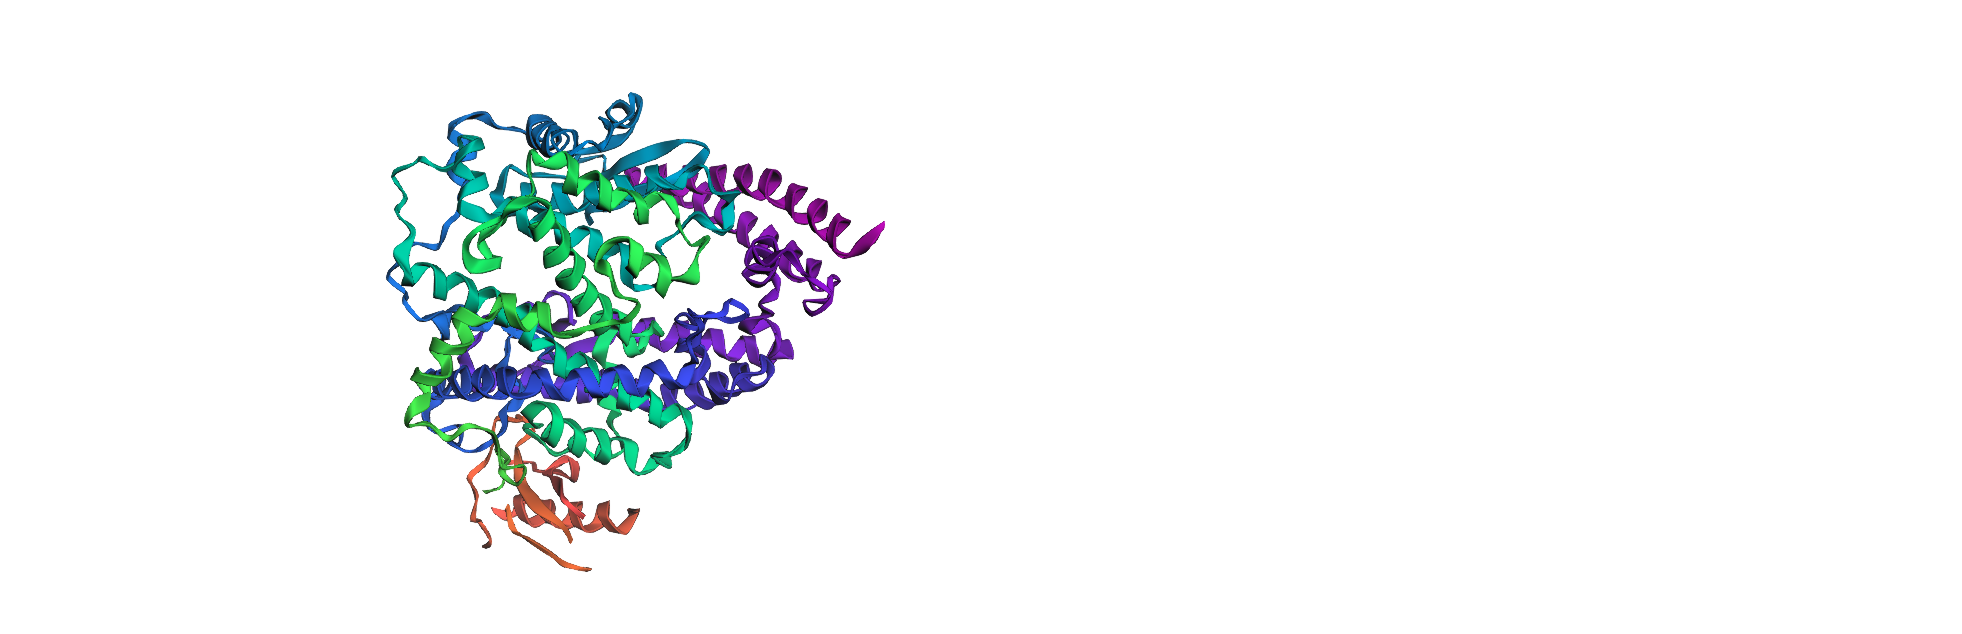

#### **RFdiffusion**

RFdiffusion applies generative diffusion techniques to create novel protein structures. It excels in designing complex protein architectures including binders and assemblies.

In [60]:
api_url = 'https://health.api.nvidia.com/v1/biology/ipd/rfdiffusion/generate'

In [63]:
# RFDiffusion input
reference_chain = 'A'
reference_residue_start = 20
reference_residue_end = 600
binder_length = 50
contigs = f'{reference_chain}{reference_residue_start}-{reference_residue_end}/0 {binder_length}-{binder_length}'
hotspot_res = ["A50","A51","A52","A53","A54"]
diffusion_steps = 15

# Pass the inference requests with JSON payload to Nvidia Server
rfdiffusion_request = requests.post(
    url = api_url,
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}'
    },
    json = {
        'input_pdb': get_reduced_pdb(),
        'contigs': contigs,
        'hotspot_res': hotspot_res,
        'diffusion_steps': diffusion_steps
    }
)

binder_pdb_content = json.loads(rfdiffusion_request.text)['output_pdb']
binder_pdb_fname = 'de-novo-protein-design/RFDiffusion_output.pdb'
binder_pdb_path = Path(binder_pdb_fname)
binder_pdb_path.write_text(binder_pdb_content)

169108

In [70]:
print('\n'.join(binder_pdb_content.split('\n')[:5]))
print('\n'.join(binder_pdb_content.split('\n')[-5:]))

ATOM      1  N   GLY A   1     -19.486   9.600  -8.627  1.00  0.00
ATOM      2  CA  GLY A   1     -20.145   9.489  -7.331  1.00  0.00
ATOM      3  C   GLY A   1     -20.095   8.059  -6.808  1.00  0.00
ATOM      4  O   GLY A   1     -20.236   7.107  -7.572  1.00  0.00
ATOM      5  N   GLY A   2     -19.495   7.862  -5.841  1.00  0.00
ATOM   2521  N   LYS B 631     -27.321 -16.967  10.145  1.00  1.00
ATOM   2522  CA  LYS B 631     -28.015 -17.905  11.019  1.00  1.00
ATOM   2523  C   LYS B 631     -28.800 -18.932  10.214  1.00  1.00
ATOM   2524  O   LYS B 631     -28.865 -20.110  10.581  1.00  1.00



In [ ]:
view = py3Dmol.view(width=600, height=400)
with open(pdb_file) as ifile:
  system = ''.join([x for x in ifile])

view.addModelsAsFrames(system)

view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
view.setStyle({'model': -1, 'chain': 'B'},{'cartoon': {'hidden': True}})
view.setStyle({'model': -1, 'chain': 'C'},{'cartoon': {'hidden': True}})
view.setStyle({'model': -1, 'chain': 'D'},{'cartoon': {'hidden': True}})
view.setStyle({'model': -1, 'chain': 'E'},{'cartoon': {'hidden': True}})
'''
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.addModelsAsFrames(binder_pdb_content)
view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
'''
view.zoomTo()
view.show()

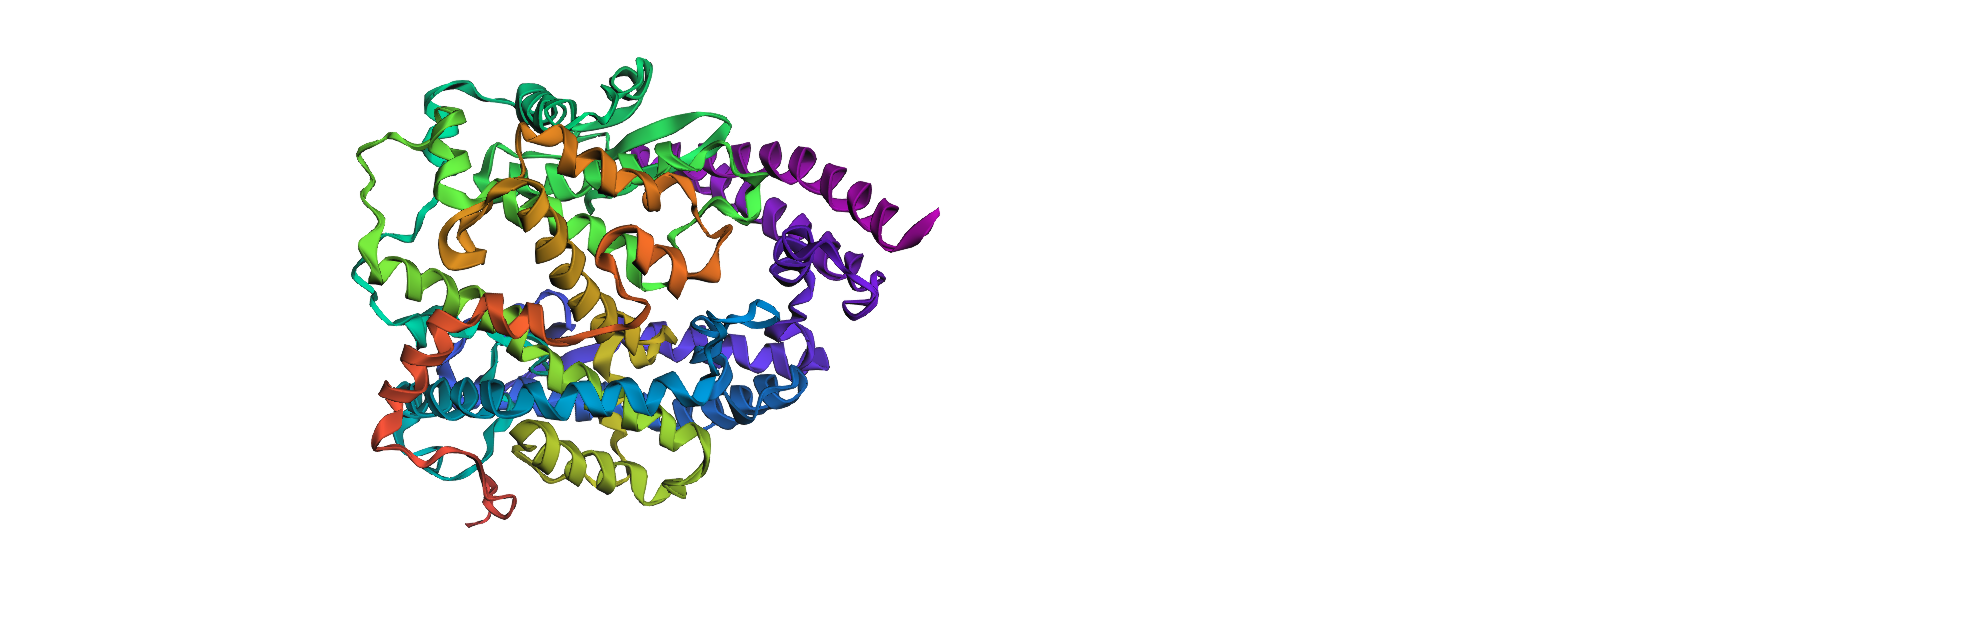

In [81]:
# Use Bio.PDB to align the structures, chain A from 1R42 and chain B from output
parser = Bio.PDB.PDBParser(QUIET=True)
ref_structure = parser.get_structure(pdb_id, pdb_file)
binder_structure = parser.get_structure('binder', binder_pdb_fname)

# CA atom of first residue in chain B from the RFDiffusion output file
# is the CA atom of the first residue in the config specification of 1R42.
binder_point = list(binder_structure[0]['B'])[0]['CA'].get_coord()
ref_point = ref_structure[0]['A'][reference_residue_start]['CA'].get_coord()
transformation = ref_point - binder_point
binder_structure.transform(np.eye(3), transformation)

# Save the aligned output for visualization
io = PDBIO()
io.set_structure(binder_structure)
aligned_pdb_fname = 'de-novo-protein-design/RFDiffusion_output_aligned.pdb'
aligned_binder_pdb_path = Path(aligned_pdb_fname)
io.save(aligned_pdb_fname)

In [ ]:
# Visualize chains aligned
view = py3Dmol.view(width=400, height=400)
with open(pdb_file) as ifile:
  system = ''.join([x for x in ifile])

view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
view.setStyle({'model': -1, 'chain': 'B'},{'cartoon': {'color': 'blue'}})
view.setStyle({'model': -1, 'chain': 'C'},{'cartoon': {'color': 'red'}})
view.setStyle({'model': -1, 'chain': 'D'},{'cartoon': {'color': 'orange'}})
view.setStyle({'model': -1, 'chain': 'E'},{'cartoon': {'color': 'green'}})
view.zoomTo()

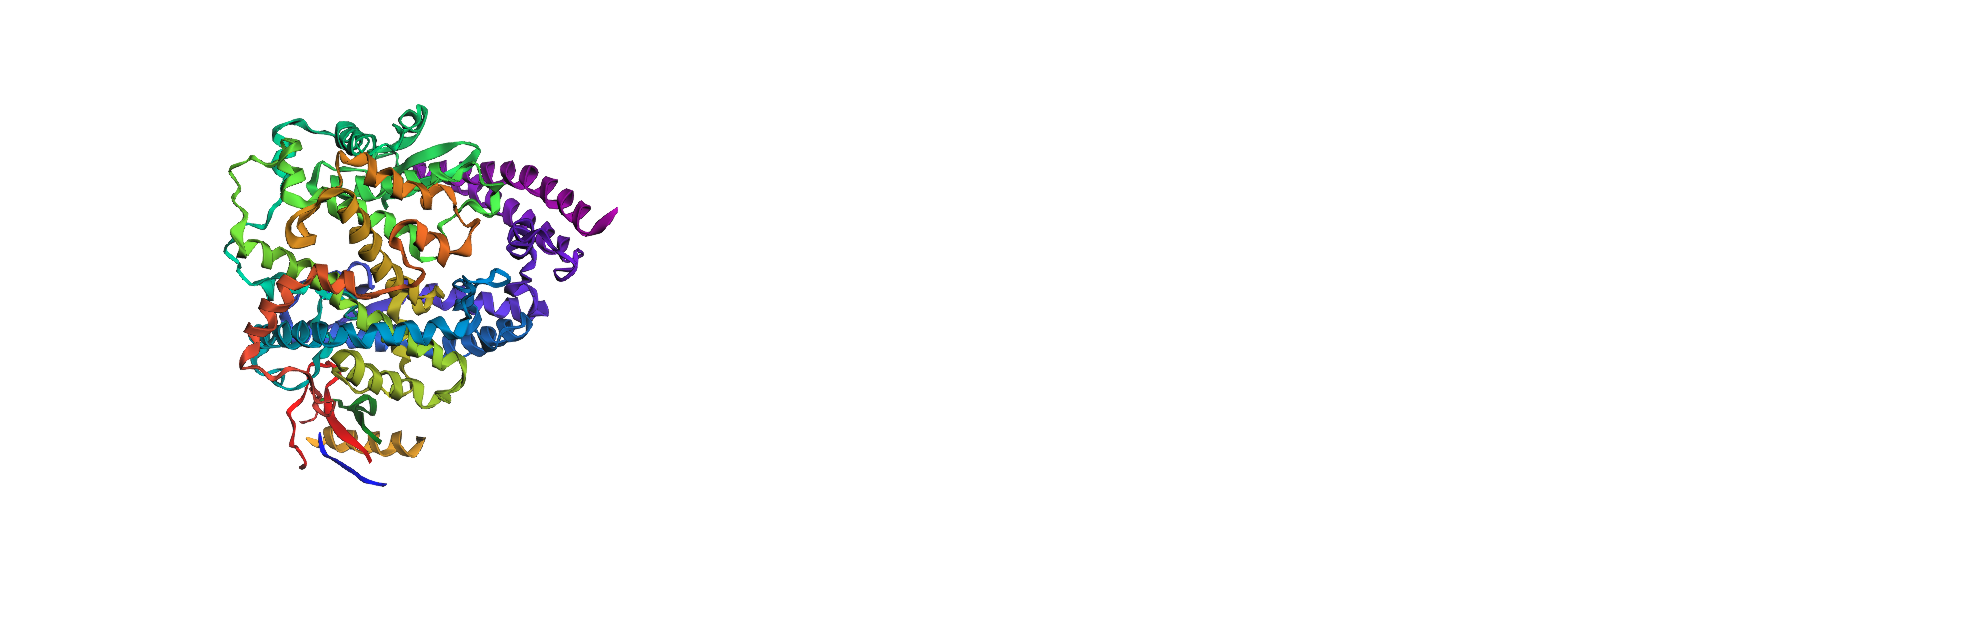

In [ ]:
with open(aligned_pdb_fname) as ifile:
  system = ''.join([x for x in ifile])

# configure structure dispaly
view.addModelsAsFrames(system)
# designed structure
view.setStyle({'model': -1, 'chain': 'A'}, {'cartoon': {'color': 'red'}})
# reference that's input to RFDiffusion
view.setStyle({'model': -1, 'chain': 'B'}, {'cartoon': {'color': 'green'}})
view.zoomTo()
view.show()

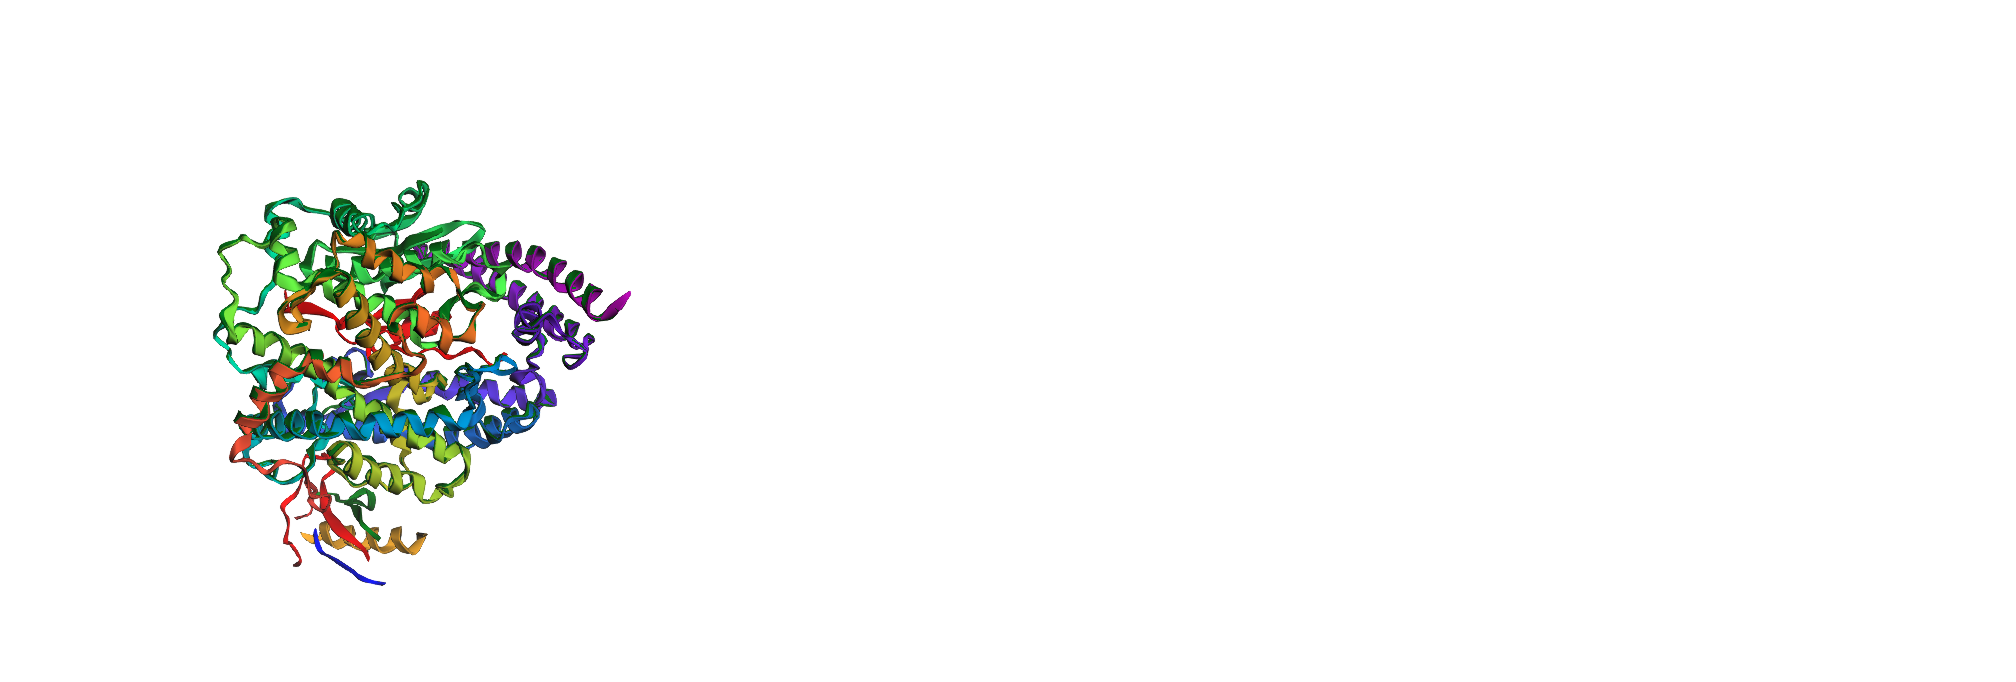

#### **ProteinMPNN**

Protein Message Passing Neural Network is a deep learning based graph neural network in the DeNovo protein design. It predicts amino acids sequences for given protein backbones and leveraging the structural information it generates sequences that are likely to fold into desired 3D structures.

In [154]:
api_url = 'https://health.api.nvidia.com/v1/biology/ipd/proteinmpnn/predict'

In [155]:
# Protein MPNN params
ca_only = False,
use_soluble_model = False,
sampling_temp = [0.5]
num_seq_per_target = 20

# Read the content of the binder PDB file
if aligned_binder_pdb_path.exists():
  input_pdb_content = aligned_binder_pdb_path.read_text()
else:
  raise FileNotFoundError(f'{aligned_binder_pdb_path} does not exist')

# Pass the Json payload to the inference server
proteinMPNN_request = requests.post(
    url = api_url,
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {api_key}"
    },
    json={
        "input_pdb": input_pdb_content,
        "input_pdb_chains": ["A"],
        "ca_only": False,
        "use_soluble_model": False,
        "sampling_temp": [0.5],
        "num_seq_per_target": num_seq_per_target
    },
)

In [156]:
output_fa_content = json.loads(proteinMPNN_request.text)['mfasta']
output_fa_path = Path('de-novo-protein-design/proteinMPNN_output.fa')
output_fa_path.write_text(output_fa_content)

2676

In [161]:
output_fa_content.split('\n')[1::2]

['GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG',
 'AQPAFAVSTGGAFCESNTVVLERGLHRGDESGPDCETESGQVDAFSVPLS',
 'AQPLSAVAIGAAFDSANTIVRKMGFHRAGREGPLGTTEKSAVSSYSKRLL',
 'KQPANAVSIGGAMSSENSVIFKHGFDRGERSGPLGPTEVGAIDSFSTKLE',
 'HQPAHAVAIGGAFPAQNSEIVKKGFHKGGSEGPLGPLTTGQIDSESKKIS',
 'ALPANAVAIGGGYSSENTEIIKDGFHKAEREGPLGYPHTGTAMAESKPLV',
 'AKPLNAVAIGGSYSENNTVITKVGYHRGGGSGPLGPNEYSSIGAYSQPLS',
 'SQPASAVSIGGAHDASISEIFKKGLHYEGSSGPMGPQEIGVINAESVPNL',
 'SQPANAVSIGGAYSSENGVVHQKGLHYSEGDGPLGPVEVSAEDAYSNPLL',
 'SLPANAISVGAAHSSDNTIIIKRGIHLGDSSGPLGPSMKGKDDAVSMPLQ',
 'SQPAWAVAIGGSYDSKNTDVYKDGFHYPHTSGPHGPSSLGGVSCMSRPLF',
 'RKPAFGVAIGASYGPENIEIMKRGLHRAGRGGPLGPTERGQDSSYSEPLL',
 'TQPAFGAAIGGAHTRENSKVHELGLHRAHEEGPLGPIHYGWESSSSTPLI',
 'AEPAFGVSIGGSHTEENIEINKMGLHLGGRSGPLGPKETSGVDSVSAKLQ',
 'MSPARASAIGGSYTQENTEIFKIGMHEAESSGPLGPSEISSSASHSPLLY',
 'SQPLNAVSIGGGLSQMNSDIYKDGFWLIGHSGPLGPNAIGCVGSESKKLS',
 'ARPADAVAIGGALGPENTGIVKDGFHEGGESGPLGPPETFTVSSFSIPLE',
 'AQPAFAVAIGGAYDESFSDIIKTGLHESERSGPLGQTEVGGVNSFSKPLL',
 'KQPAYGTA

#### **Validate Designs**

After designing the sequences with the ProteinMPNN we can use a range of methods to validate the sequences.

- Use AlphaFold to predict the structures of the designed sequences and judge by their pLDDT scores, a metric for model's confidence of prediction.
- Use AlphaFold2 without MSA and judge by pLDDT scores.
- Use AlphaFold2 Multimer to model the complex. AlphaFold2 builds on the success of AlphaFold in protein structure design.

In [ ]:
api_url = "https://health.api.nvidia.com/v1/protein-structure/alphafold2/multimer/predict-structure-from-sequences/"

headers = {
    "Authorization": f"Bearer {api_key}",
    "Accept": "application/json",
    "Content-Type": "application/json"
}
sequences = ["MNVIDIAIAMAI", "NESKHCAWVMIPTFRQYDGL"]
data = {
    "sequences": sequences,
    "algorithm": "jackhmmer",
    'iterations': 1,
    "databases": ["small_bfd"],
    "e_value": 0.000001,
    "num_predictions_per_model" : 1,
    "relax_prediction": False,
}

response = requests.post(api_url, headers=headers, data=json.dumps(data))
# Check if the request was successful
if response.ok:
    with open("output.pdb", "w") as ofi:
        ofi.write(json.dumps(response.json()))
    print("Request succeeded:", response.json())
else:
    print("Request failed:", response.status_code, response.text)

In [165]:
output_fa_path = Path('de-novo-protein-design/proteinMPNN_output.fa')
input_fa_content = output_fa_path.read_text()

#condense sequences for text processing
seqs = [x for x in input_fa_content.strip().split('\n') if '>' not in x]

**Calculate Average pLDDT**

Compute local distance difference test score across all residues in a protein structure. The values extracted from B-factor column in PDB files, provide a confidence metric for the predicted atomic positions. High pLDDT values indicate greater confidence in structural prediction. The calculated average pLDDT is used to assess the quality of AlphaFold2-multimer generated structure.

In [207]:
alphafold_results_dir = 'alphafold_results'

In [233]:
# calculate the average pLDDT over all residues
def calculate_avg_pLDDT(pdb_string):
    total_pLDDT, atom_count, pdb_lines = 0.0, 0, pdb_string.splitlines()
    for line in pdb_lines:
        if line.startswith("ATOM"):
            atom_name = line[12:16].strip()
            if atom_name in ["CA"]:
                atom_count += 1
                pLDDT = float(line[60:66].strip())
                total_pLDDT += pLDDT
    return total_pLDDT / atom_count if atom_count > 0 else 0.0

In [236]:
# List the average B factors of these outputs
pLDDTs = []
for idx in [0, 1, 10, 11, 12, 13, 14, 15, 16, 17]:
    with open(os.path.join(alphafold_results_dir, f'folded_protein_seq{idx}.pdb')) as ifile:
        pdb_string = ifile.read()
        pLDDTs.append(calculate_avg_pLDDT(pdb_string))

**Calculate RMSD**

Root Mean Square Deviation quantifies the structural deviation between two sets of atomic coordinates. We use it to measure how closely a designed protein backbone aligns with its folded structure. Lower RMSD values indicate better alignment and structural similarity.

In [209]:
def calc_RMSD(coord1, coord2):
    return np.sqrt(np.mean(np.square(coord1 - coord2)))

**Compare Designed and Folded Structures**

In [227]:
!head alphafold_results/folded_protein_seq0.pdb

ATOM      1  N   GLU A   1     -14.528  14.146 -25.346  1.00 13.68           N  
ATOM      2  H   GLU A   1     -15.255  14.575 -24.791  1.00 13.68           H  
ATOM      3  H2  GLU A   1     -14.783  14.112 -26.322  1.00 13.68           H  
ATOM      4  H3  GLU A   1     -14.329  13.221 -24.992  1.00 13.68           H  
ATOM      5  CA  GLU A   1     -13.291  14.921 -25.194  1.00 13.68           C  
ATOM      6  HA  GLU A   1     -12.511  14.471 -25.808  1.00 13.68           H  
ATOM      7  C   GLU A   1     -12.844  14.625 -23.756  1.00 13.68           C  
ATOM      8  CB  GLU A   1     -13.486  16.357 -25.732  1.00 13.68           C  
ATOM      9  HB2 GLU A   1     -14.278  16.845 -25.165  1.00 13.68           H  
ATOM     10  HB3 GLU A   1     -12.559  16.923 -25.640  1.00 13.68           H  


In [223]:
!head alphafold_aligned/seq0.pdb

ATOM      1  N   GLU A   1      49.253  84.326  -6.474  1.00 13.68           N  
ATOM      2  H   GLU A   1      49.882  84.208  -7.256  1.00 13.68           H  
ATOM      3  H2  GLU A   1      48.753  85.201  -6.534  1.00 13.68           H  
ATOM      4  H3  GLU A   1      49.770  84.264  -5.608  1.00 13.68           H  
ATOM      5  CA  GLU A   1      48.292  83.217  -6.462  1.00 13.68           C  
ATOM      6  HA  GLU A   1      47.601  83.354  -5.630  1.00 13.68           H  
ATOM      7  C   GLU A   1      49.134  82.004  -6.044  1.00 13.68           C  
ATOM      8  CB  GLU A   1      47.431  83.238  -7.745  1.00 13.68           C  
ATOM      9  HB2 GLU A   1      48.081  83.129  -8.612  1.00 13.68           H  
ATOM     10  HB3 GLU A   1      46.702  82.428  -7.722  1.00 13.68           H  


In [293]:
binder_CA = [x['CA'] for x in list(binder_structure)[0]['A'] ]
binder_CA_coord = np.array([x.get_coord() for x in binder_CA])
RMSDs = []
si = Bio.PDB.Superimposer()
for idx in [0, 1, 10, 11, 12, 13, 14, 15, 16, 17]:
    with open(os.path.join(alphafold_results_dir, f'folded_protein_seq{idx}.pdb')) as ifile:
        folded_pdb_string = ifile.read()
    pid = f'seq{idx}'
    unaligned_alphafold = parser.get_structure(pid, os.path.join(alphafold_results_dir, f'folded_protein_seq{idx}.pdb'))
    folded_CA = [x['CA'] for x in list(unaligned_alphafold)[0]['A'] ]
    si.set_atoms(binder_CA, folded_CA)
    si.apply(unaligned_alphafold)
    folded_CA_coord = np.array([x.get_coord() for x in folded_CA])
    RMSDs.append(calc_RMSD(binder_CA_coord, folded_CA_coord))
RMSDs = np.array(RMSDs)

In [294]:
RMSDs

array([7.33281261, 5.78913303, 8.11695834, 8.53576592, 7.39808115,
       7.42255585, 7.32187306, 6.97654247, 6.5765289 , 7.62037942])

In [267]:
pLDDTs = np.array(pLDDTs)
pLDDTs

array([85.17593985, 85.2856391 , 85.75288722, 85.88213534, 86.04348872,
       86.55066165, 86.76870677, 87.18944361, 87.2578797 , 88.77380451])

**List Structural Metrics**

In [278]:
list(zip(RMSDs, pLDDTs))

[(np.float64(5.789133031758742), np.float64(85.17593984962399)),
 (np.float64(6.5765288950181215), np.float64(85.28563909774432)),
 (np.float64(6.976542465836686), np.float64(85.75288721804515)),
 (np.float64(7.3218730627502815), np.float64(85.88213533834582)),
 (np.float64(7.332812606480812), np.float64(86.04348872180451)),
 (np.float64(7.398081146993592), np.float64(86.55066165413528)),
 (np.float64(7.422555845951338), np.float64(86.76870676691735)),
 (np.float64(7.620379423445311), np.float64(87.18944360902255)),
 (np.float64(8.116958344853707), np.float64(87.25787969924815)),
 (np.float64(8.535765916593048), np.float64(88.77380451127831))]

**Ranking Protein Design**

We use a ranking function to sort first the sequences, and designs with lower RMSD and higher pLDDT are ranked higher.

In [301]:
def ranking(scores, m):
    return sorted(scores) if m ==1 else sorted(scores, reverse=True)

def combined_ranking(pLDDTs, RMSDs):
    RMSDs = ranking((RMSDs), m=1)
    pLDDTs = ranking((pLDDTs), m=2)
    return np.mean([RMSDs, pLDDTs], axis=0)

ranking_results = combined_ranking(pLDDTs, RMSDs)
ranking_results

array([47.28146877, 46.9172043 , 47.08299304, 47.04528991, 46.94173713,
       46.72078493, 46.65234559, 46.68663332, 46.70129872, 46.85585288])

**Identifying the Best Design**

In [300]:
best_sequence = np.argmin(ranking_results)
best_sequence

np.int64(6)

#### **Visualize the best design**

In [ ]:
# Visualize the predicted structure save in PDB file
view = py3Dmol.view(width=600, height=400)
with open(pdb_file) as ifile:
  system = ''.join([x for x in ifile])
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {'cartoon': {'color': 'orange'}})

with open(aligned_pdb_fname) as ifile:
  system = ''.join([x for x in ifile])
view.addModelsAsFrames(system)
view.setStyle({'model': -1, 'chain': 'A'}, {'cartoon': {'color': 'green'}})
view.setStyle({'model': -1, 'chain': 'B'}, {'cartoon': {'hidden': True}})

with open(os.path.join(alphafold_results_dir, f'folded_protein_seq15.pdb')) as ifile:
  system = ''.join([x for x in ifile])
view.addModelsAsFrames(system)
pLDDT = calculate_avg_pLDDT(system)
view.setStyle({'model': -1, 'chain': 'A'}, {'cartoon': {'color': 'blue'}})
#view.setStyle({'model': -1, 'chain': 'B'}, {'cartoon': {'hidden': True}})

view.zoomTo()
view.show()

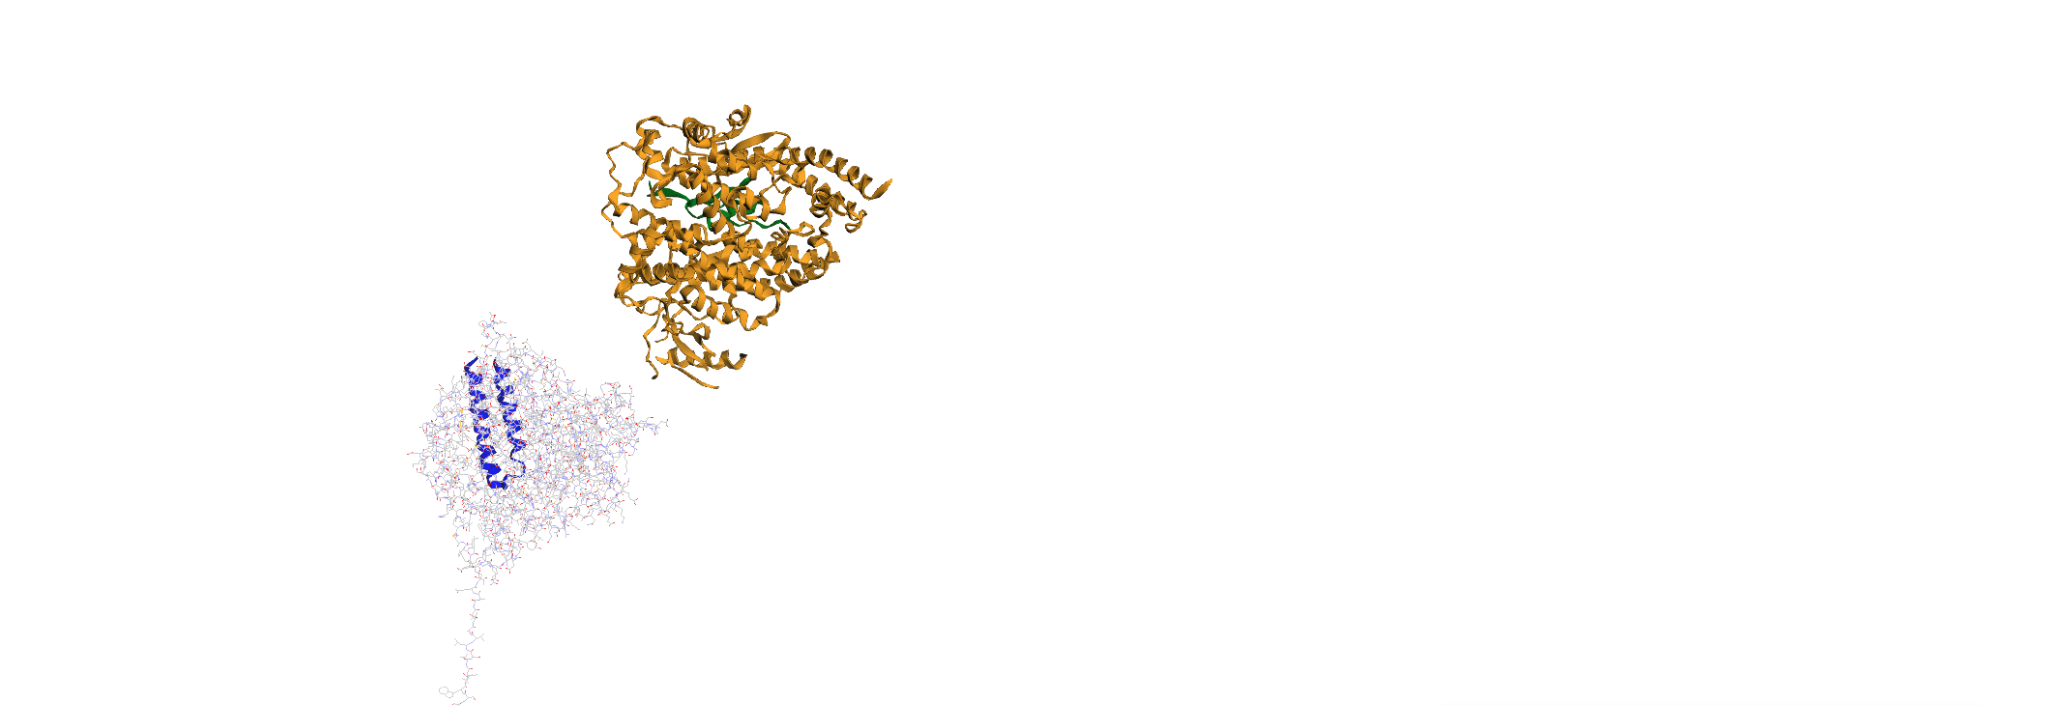